<a href="https://colab.research.google.com/github/sonusajid004/DeepLearning_models/blob/master/MonkeyBreedClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#Link to dataset --- https://drive.google.com/file/d/1l-7wsAaDi89TpaFPjFW-oS8pdgSn_ekw/view

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/datasets/monkey_breed.zip"

In [5]:
import keras
from keras.applications import MobileNet


img_rows,img_cols = 224,224

# Re-loads the MobileNet model without the top or FC layers
MobileNet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Layers are set to trainable as True by default
for layer in MobileNet.layers:
    layer.trainable = False

# Let's print our layers 
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

17227776/17225924 [==============================] - 0s 0us/step
0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False


In [6]:
def addTopModelMobileNet(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model


num_classes = 10

FC_Head = addTopModelMobileNet(MobileNet, num_classes)

In [12]:
model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/monkey_breed/train'
validation_data_dir = '/content/monkey_breed/validation'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [14]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("./monkey_breed_mobileNet.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 1097
nb_validation_samples = 272

# We only train 5 EPOCHS 
epochs = 5
batch_size = 16

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
68/68 [==============================] - 215s 3s/step - loss: 1.9956 - accuracy: 0.4709 - val_loss: 1.7471 - val_accuracy: 0.6402

Epoch 00001: val_loss improved from inf to 1.74706, saving model to ./monkey_breed_mobileNet.h5
Epoch 2/5
68/68 [==============================] - 212s 3s/step - loss: 0.6947 - accuracy: 0.7903 - val_loss: 0.2165 - val_accuracy: 0.9043

Epoch 00002: val_loss improved from 1.74706 to 0.21649, saving model to ./monkey_breed_mobileNet.h5
Epoch 3/5
68/68 [==============================] - 211s 3s/step - loss: 0.4736 - accuracy: 0.8523 - val_loss: 0.4293 - val_accuracy: 0.9160

Epoch 00003: val_loss did not improve from 0.21649
Epoch 4/5
68/68 [==============================] - 213s 3s/step - loss: 0.4282 - accuracy: 0.8774 - val_loss: 0.1818 - val_accuracy: 0.9395

Epoch 00004: val_loss improved from 0.21649 to 0.18178, saving model to ./monkey_breed_mobileNet.h5
Epoch 5/5
68/68 [==============================] - 217s 3s/step - loss: 0.4048 - accuracy

In [19]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np




validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
        )

class_labels = validation_generator.class_indices
classes = list(class_labels.keys())
print(classes)

y_pred = model.predict_generator(validation_generator,verbose=1,use_multiprocessing=True)
y_pred = np.argmax(y_pred,axis=1)





Found 272 images belonging to 10 classes.
['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
17/17 [==============================] - 24s 1s/step


In [22]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[25  0  0  0  0  0  0  0  0  1]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  1 25  0  0  0  0  1  0  0]
 [ 0  1  0 29  0  0  0  0  0  0]
 [ 0  0  0  0 26  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  3  0  0]
 [ 0  0  1  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0 28  0  0]
 [ 1  0  0  0  0  0  0  3 23  0]
 [ 0  0  1  0  0  0  0  0  0 25]]


In [24]:
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=classes))


Classification Report
              precision    recall  f1-score   support

          n0       0.96      0.96      0.96        26
          n1       0.93      1.00      0.97        28
          n2       0.93      0.93      0.93        27
          n3       1.00      0.97      0.98        30
          n4       1.00      1.00      1.00        26
          n5       1.00      0.89      0.94        28
          n6       1.00      0.96      0.98        26
          n7       0.80      1.00      0.89        28
          n8       1.00      0.85      0.92        27
          n9       0.96      0.96      0.96        26

    accuracy                           0.95       272
   macro avg       0.96      0.95      0.95       272
weighted avg       0.96      0.95      0.95       272



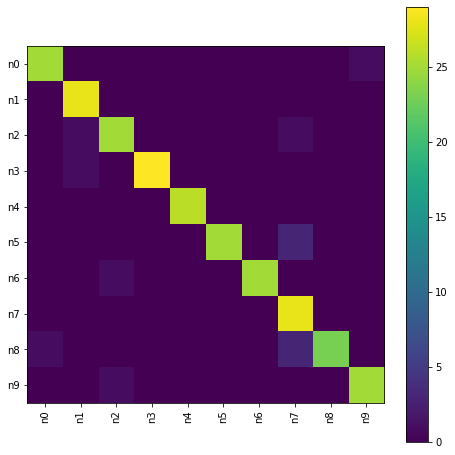

In [25]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)